In [1]:
#| default_exp training

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [3]:
# fastai utility to help with testing if the func
from fastcore.test import test_close

# edit formating of print statements
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

# set a random seed
torch.manual_seed(1)

# customizing matplotlib plot style
mpl.rcParams['image.cmap'] = 'gray'

# define path to where the data is
# loading the dataset into memory in validation sets and turning them into a tensor
# notice it is put in a list for easy recovery
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Initial setup

### Data

In [4]:
# take the tuple: store the number of rows(n) and columns (m)
n,m = x_train.shape

# defining the target for the mnist to also include the highest number
c = y_train.max()+1

# nh means number of hidden layers
nh = 50

In [5]:
# class inheritance from nn.module
# Helps make a MLP with 3 layers
# idea emoji: the call enables you to call the class like a function e()
# NB: the call allows us to index into the arch and get specific layers which are a list
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [6]:
m

784

In [7]:
# make a MLP with 784 number of inputs(28 * 28) (m), 50 number of hidden layers (nh) and 10 number of outputs
# instantiate that parameters
model = Model(m, nh, 10)

# apply to the feature set
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [8]:
# indexing into the arch
model.layers[0]

Linear(in_features=784, out_features=50, bias=True)

In [9]:
getattr(model, "layers")

[Linear(in_features=784, out_features=50, bias=True),
 ReLU(),
 Linear(in_features=50, out_features=10, bias=True)]

In [10]:
pred

tensor([[-0.09, -0.21, -0.08,  ..., -0.03,  0.01,  0.06],
        [-0.07, -0.14, -0.14,  ...,  0.03,  0.04,  0.14],
        [-0.19, -0.04,  0.02,  ..., -0.01, -0.00,  0.02],
        ...,
        [-0.03, -0.22, -0.04,  ..., -0.01,  0.09,  0.14],
        [-0.10, -0.09, -0.05,  ..., -0.01,  0.02,  0.11],
        [-0.03, -0.25, -0.06,  ...,  0.00,  0.03,  0.14]], grad_fn=<AddmmBackward0>)

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [11]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

If we just use the softmax we will get numbers in a small scale. We add the logarithm in order to fix the problem.

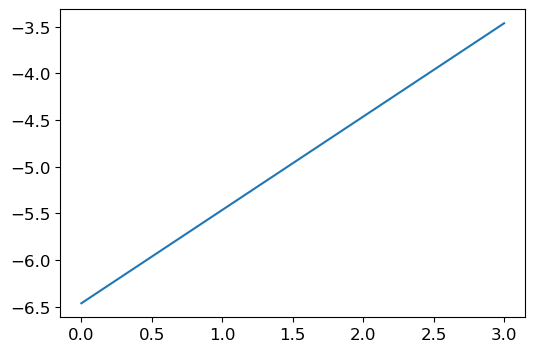

In [12]:
# use plot_function to see this
from fastbook import *
plot_function(log_softmax, min=0, max=3)

In [13]:
log_softmax(pred) # apply log 

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax:

In [14]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log() 

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [15]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [16]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True) #pytorch implementation

In [17]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [18]:
y_train[:3]

tensor([5, 0, 4])

In [19]:
sm_pred[2], y_train[4]

(tensor([-2.48, -2.33, -2.28, -2.09, -2.36, -2.30, -2.38, -2.30, -2.30, -2.27], grad_fn=<SelectBackward0>),
 tensor(9))

In [20]:
# indexing into arrays
# remember they are 10 predictions for each array
# we take the first array fifth element(its a 5, second element is a 0 and the third is 9
# here we are grabbing a subset of the predictions
sm_pred[0,5],sm_pred[1,0],sm_pred[2,4]

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

In [21]:
sm_pred[[0,1,2], y_train[:3]] # compact way

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [22]:
# negative log loss
# making the loss function
# median gives the same answer but numbers are dropped in the calculation
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [23]:
# implement
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

Then use PyTorch's implementation.

In [24]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3) # compare with pytorch

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [25]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3) # they are the same

Therefore, we run the log of softmax then do a negative log likelihood. This is called the **cross-entropy loss**. 

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [26]:
loss_func = F.cross_entropy

In [27]:
bs=50                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [28]:
preds.shape, xb.shape # notices that number of rows is retained i.e the number of predictions

(torch.Size([50, 10]), torch.Size([50, 784]))

In [29]:
yb = y_train[0:bs] # grab the same batch size of the images
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3])

In [30]:
loss_func(preds, yb) #apply the loss function which is negative log likelihood

tensor(2.30, grad_fn=<NllLossBackward0>)

In [31]:
preds.argmax(dim=1) # on the predictions we find the indexes

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8, 3, 5, 9, 5, 9, 5])

In [32]:
#|export
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [33]:
accuracy(preds, yb) # 80% accuracy on average

tensor(0.08)

In [34]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for

Formatting the output of the training

In [35]:
#|export
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [36]:
# take a batch of Xs and ys
# store them in variables
xb,yb = x_train[:bs],y_train[:bs]

# apply the MLP
preds = model(xb)

# see results formatted in a better manner
report(loss_func(preds, yb), preds, yb)

2.30, 0.08


In [37]:
# for the whole dataset
# minibatch training
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs)) # helps to grab a mini batch
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        
        # Optimizer section: Stochastic gradient descent
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr # update the weights
                    l.bias   -= l.bias.grad   * lr # update the bias
                    l.weight.grad.zero_() # zeroing gradients
                    l.bias  .grad.zero_() # zeroing bias
    report(loss, preds, yb)

0.12, 0.98
0.12, 0.94
0.08, 0.96


## Using parameters and optim

### Parameters

In [38]:
# instantiate nn.module used by NN
m1 = nn.Module() 

# name the linear layer foo
m1.foo = nn.Linear(3,4) 

In [39]:
list(m1.named_children()) # get the named linear layer called foo

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [40]:
m1.named_children() # returns a generator without list command

<generator object Module.named_children at 0x7ff4378db220>

In [41]:
list(m1.parameters()) # see the parameters of the module

[Parameter containing:
 tensor([[ 0.44,  0.48, -0.14],
         [ 0.53, -0.13,  0.12],
         [-0.28,  0.34,  0.51],
         [-0.42,  0.50,  0.11]], requires_grad=True),
 Parameter containing:
 tensor([ 0.43,  0.08,  0.28, -0.08], requires_grad=True)]

In [42]:
# class inheritance and write our own nn.Module MLP
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()
        
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [43]:
# add the arguments to the MLP
model = MLP(m, nh, 10)

# we use dot notation to grab the parameter
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [44]:
model # see the named module as class name & parameters

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [45]:
#  iterate over the model children and print the named parameters
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [46]:
for p in model.parameters(): print(p.shape) # apply function over named parameters

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [47]:
# fit function responsible for the training loop
def fit():
    for epoch in range(epochs): # training step
        for i in range(0, n, bs): # do training on the batch
            s = slice(i, min(n,i+bs)) # pick a slice of the data
            xb,yb = x_train[s],y_train[s] # grab a batch of the feature and target same section
            preds = model(xb) # predict on the batch 
            loss = loss_func(preds, yb) # calculate the loss function
            loss.backward() # backprop
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr # adjust weights and multiply by learning rate
                model.zero_grad() # zero the gradients
        report(loss, preds, yb) # see how you are doing

In [48]:
fit()

0.12, 0.96
0.07, 0.98
0.05, 0.98


Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [49]:
class MyModule:
    def __init__(self, n_in, nh, n_out): # defines regular MLP storing parameters in dict
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)

    def __setattr__(self,k,v): # picking certain parameters startswith
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)

    def __repr__(self): return f'{self._modules}' # allows better printing of objects
    
    def parameters(self): # loop in _modules and see the parameters
        for l in self._modules.values(): yield from l.parameters()

In [50]:
mdl = MyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [51]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering modules

In [52]:
from functools import reduce

We can use the original `layers` approach, but we have to register the modules.

In [53]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [54]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

    def forward(self, x): return reduce(lambda val,layer: layer(val), self.layers, x)

In [55]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [56]:
model(xb).shape

torch.Size([50, 10])

### nn.ModuleList

`nn.ModuleList` does this for us.

In [57]:
class SequentialModel(nn.Module): # moving to sequential model
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [58]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [59]:
fit()

0.15, 0.94
0.11, 0.98
0.10, 0.98


### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [60]:
# we were building the previous naming of the manual naming to using pytorch
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [61]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.16, 0.94
0.14, 0.96
0.12, 0.94


(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))

In [62]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

In [63]:
# model update step: SGD 
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [64]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [65]:
opt = Optimizer(model.parameters())

In [66]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.16, 0.96
0.10, 0.96
0.05, 0.98


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later)

In [67]:
from torch import optim

In [68]:
# compress model into a function save the model and results
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [69]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [70]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.10, 0.98
0.06, 1.00
0.03, 1.00


## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[s]
    yb = y_train[s]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[s]
```

In [71]:
#|export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y # stores value of x and y in a tuple
    def __len__(self): return len(self.x) # find the number of items in x
    def __getitem__(self, i): return self.x[i],self.y[i] # get the items in x and y via indexing

In [72]:
# use the class: use the xtrain,ytrain and validation set
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

# confirm if the structure is the same in both datasets
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [73]:
# take a batch of 5 features and labels
xb,yb = train_ds[0:5]

# check if the shape is 5 & 28 by 28
assert xb.shape==(5,28*28)

# if the y has 5 items/
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [74]:
model,opt = get_model() # run MLP

In [75]:
# run the training loop
for epoch in range(epochs): # in each epoch
    for i in range(0, n, bs): # using a particular batch
        xb,yb = train_ds[i:min(n,i+bs)] # grab defined n to batch size
        preds = model(xb) # run MLP
        loss = loss_func(preds, yb) # calculate loss function
        loss.backward() # backprop
        opt.step() # update weights
        opt.zero_grad() # zero gradients
    report(loss, preds, yb)

0.15, 0.92
0.12, 0.96
0.07, 0.96


### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [76]:
# cleaning up the dataset class with a iterator and list indexing
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [77]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [78]:
# checking the size of the validation set rows and columns
xb,yb = next(iter(valid_dl))
xb.shape

torch.Size([50, 784])

In [79]:
yb # all the targets like we wanted

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4])

tensor(3)

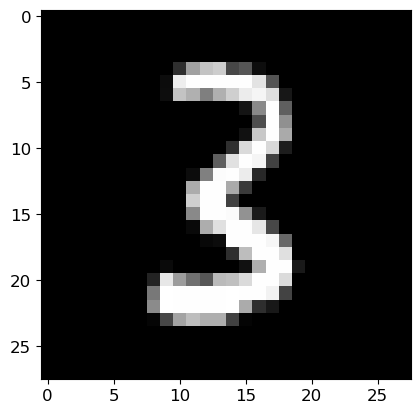

In [80]:
# view feature and the label
plt.imshow(xb[0].view(28,28))
yb[0]

In [81]:
model,opt = get_model()

In [82]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl: # changed here more concise
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [83]:
fit() # training loop

# measures of success
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.14, 0.96
0.10, 0.96
0.08, 0.96


(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [84]:
import random

In [85]:
class Sampler(): # single sampler
    def __init__(self, ds, shuffle=False): self.n,self.shuffle = len(ds),shuffle # initialize the class to have a set shuffle value and is able to calculate the len
    def __iter__(self):
        res = list(range(self.n)) # convert range to list
        if self.shuffle: random.shuffle(res) # confirms the value of shuffle and rearranges the list
        return iter(res) # enables iteration over the list

In [86]:
from itertools import islice

In [87]:
ss = Sampler(train_ds)

In [88]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


In [89]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [90]:
ss = Sampler(train_ds, shuffle=False)
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [91]:
import fastcore.all as fc

In [92]:
class BatchSampler(): # multiple sampler
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [93]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[0, 1, 2, 3],
 [4, 5, 6, 7],
 [8, 9, 10, 11],
 [12, 13, 14, 15],
 [16, 17, 18, 19]]

In [94]:
def collate(b): # collect xs and ys into a single matrix
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [95]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [96]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [97]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

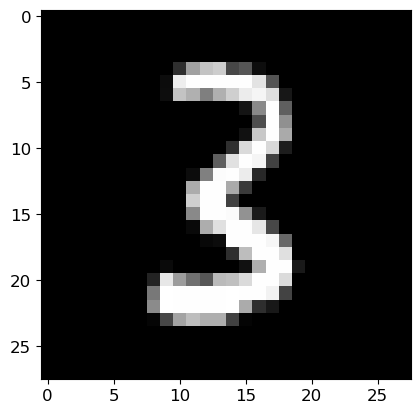

In [98]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [99]:
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [100]:
model,opt = get_model()

In [101]:
fit()

0.18, 0.06
0.03, 0.06
0.20, 0.04


### Multiprocessing DataLoader

In [102]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [103]:
len(train_ds)

50000

In [104]:
# access elements in the dataset
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [105]:
# another way of accessing elements in the dataset
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [104]:
# map the dataset to the index
for o in map(train_ds.__getitem__, ([3,6],[8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [106]:
class DataLoader():
    '''
    dataloaders are used to load data in batches and use multiprocessing to speed up the process

    ds: dataset
    batchs: batch sampler
    n_workers: number of workers to use
    collate_fn: function to collate the data into x and y

    '''
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [107]:
# use the dataloader
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [108]:
# get the first batch
xb,yb = next(it)

# check the shape of the batch
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

### PyTorch DataLoader

In [109]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [110]:
# create a dataloader with BatchSampler and RandomSampler
# batch sampler is used to create batches of data, random sampler is used to shuffle the data
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [110]:
# create the dataloader: collate_fn is used to collate the data into x and y batches in train and validation sets
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [111]:
# run the training loop: this is the same as before
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.15, 0.06
0.31, 0.20
0.03, 0.10


(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))

PyTorch can auto-generate the BatchSampler for us:

In [112]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

PyTorch can also generate the Sequential/RandomSamplers too:

In [113]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [114]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

0.10, 0.10
0.39, 0.14
0.03, 0.08


(tensor(0.02, grad_fn=<NllLossBackward0>), tensor(1.))

Our dataset actually already knows how to sample a batch of indices all at once:

In [116]:
train_ds[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

...that means that we can actually skip the batch_sampler and collate_fn entirely:

In [117]:
# create dataloader easily
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [118]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [119]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl): # training loop
    for epoch in range(epochs): # iterate over the number of epochs
        model.train() # set the model to training mode
        for xb,yb in train_dl: # iterate over the training set
            loss = loss_func(model(xb), yb) # calculate loss
            loss.backward() # calculate gradients which are stored in the .grad attribute of each parameter
            opt.step() # update the parameters
            opt.zero_grad() # reset the gradients to zero

        model.eval() # set the model to evaluation mode
        with torch.no_grad(): # disable gradient calculation
            tot_loss,tot_acc,count = 0.,0.,0 # initialize the loss, accuracy and count
            for xb,yb in valid_dl: # iterate over the validation set
                pred = model(xb) # get the predictions
                n = len(xb) # get the number of samples in the batch
                count += n # add the number of samples to the count variable
                tot_loss += loss_func(pred,yb).item()*n # calculate the loss and add it to the total loss
                tot_acc  += accuracy (pred,yb).item()*n # calculate the accuracy and add it to the total accuracy
        print(epoch, tot_loss/count, tot_acc/count) # print the epoch, loss and accuracy
    return tot_loss/count, tot_acc/count # return the loss and accuracy

In [120]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs): # create dataloaders
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs), # training dataloader
            DataLoader(valid_ds, batch_size=bs*2, **kwargs)) # validation dataloader

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [121]:
# compressed version of the training loop
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()

In [122]:
%time loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl) # in CPU

0 0.18484509313479067 0.9427000033855438
1 0.13305967260152102 0.960700004696846
2 0.15698771580122411 0.9535000020265579
3 0.10447211955441162 0.96760000705719
4 0.10551201710710302 0.9704000061750412
CPU times: user 30.5 s, sys: 302 ms, total: 30.9 s
Wall time: 3.86 s


In [123]:
# summary of notebook
# We created a training loop that can be used to train a model. 
# We also created a function to create dataloaders that can be used to load data in batches.
# We used the dataloaders to create training and validation dataloaders.
# We used the training loop to train a model on the MNIST dataset.


## Export -

In [124]:
import nbdev

In [125]:
nbdev.nbdev_export()